In [1]:
#!/zhome/44/9/212447/venv_1/bin/python3
import numpy as np
import PIL.Image as Image

# pip install torchsummary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms.v2 as TF
from model import UNet2, EncDec, EncDec2
from dataloader import SkinLesionLoader, PATCH_DRIVEDataLoader

from loss_functions import evaluate_model, evaluate_model_retinal

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

data_path = "/dtu/datasets1/02516//PH2_Dataset_images"
transform = TF.Compose([
    TF.Resize((256, 256))
    # transforms.ToTensor() # Dataloader handles this by itself
])
# Create dataset instances for train, validation, and test
#test_dataset = SkinLesionLoader(transform=transform, dataset_path=data_path, split='test')
test_dataset = PATCH_DRIVEDataLoader(transforms=transform, split='Test')
train_dataset = PATCH_DRIVEDataLoader(transforms=transform, split='Train')

#Create data loaders
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=6, shuffle=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=6, shuffle=True)

cuda


In [11]:
# Instantiate the model
model = UNet2()
#model = EncDec2()
# Load the state dict
model = torch.load('best_model_6.pt', map_location="cuda")

model.to(device)  # Move the model to the GPU if available
# Set to evaluation mode
model.eval()
print("Evaluating Model: ")
#metrics = evaluate_model(model, test_loader, device)
metrics = evaluate_model_retinal(model, test_loader, device)
for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value:.4f}")  # Format to 4 decimal places

Evaluating Model: 
tensor(0.9916, device='cuda:0')
tensor(0., device='cuda:0')
tensor(0.9916, device='cuda:0')
tensor(0., device='cuda:0')
tensor(1., device='cuda:0')
Dice: 0.9916
IoU: 0.0000
Accuracy: 0.9916
Sensitivity: 0.0000
Specificity: 1.0000


/tmp/ipykernel_567551/3970323519.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('best_model_6.pt', map_location="cuda")


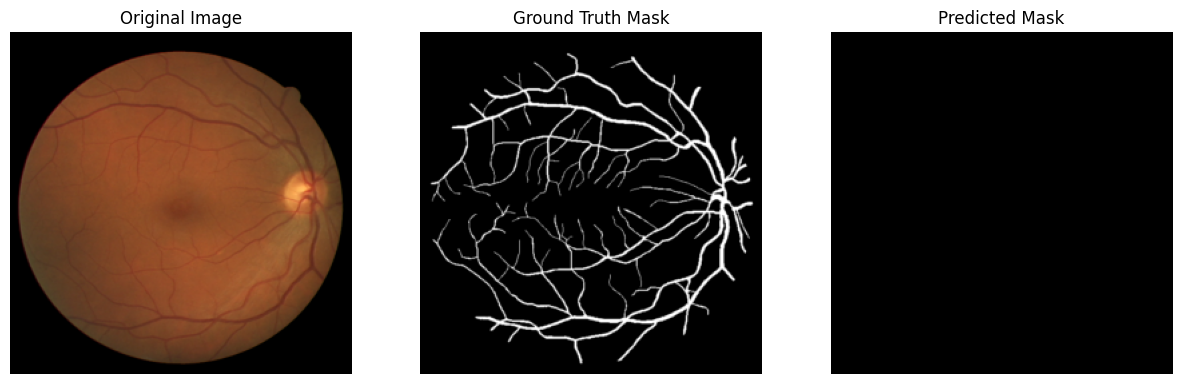

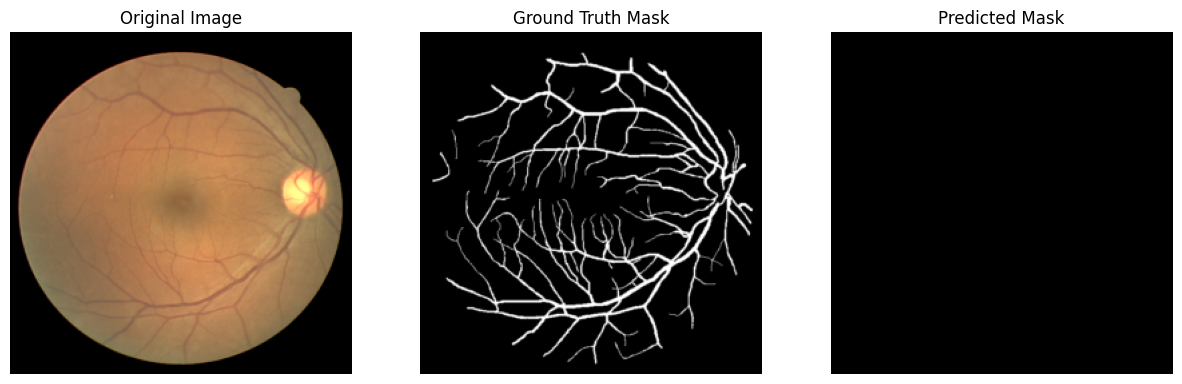

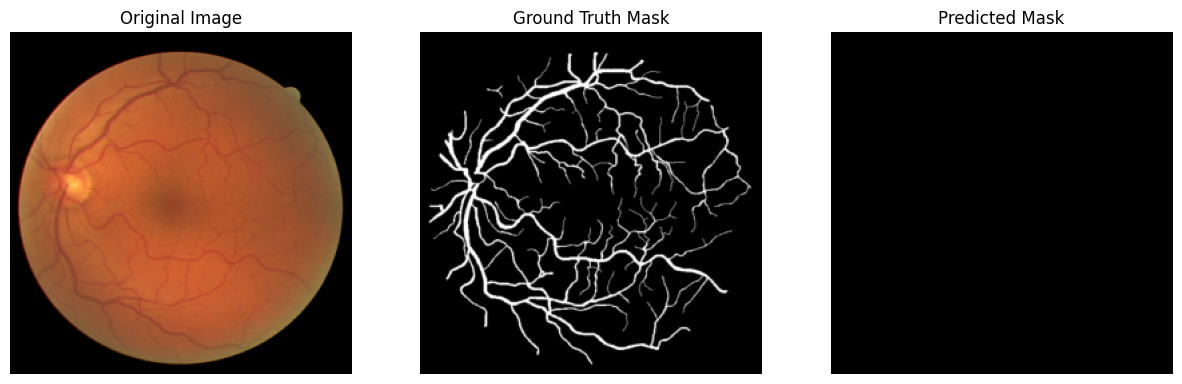

In [12]:
import matplotlib.pyplot as plt
import random
import torchvision.transforms.functional as TF  # Ensure the correct import for ToPILImage

def show_random_predictions(model, data_loader, device, num_images=3):
    model.eval()
    
    # Collect a random batch from the data loader
    for _dict in data_loader:
        images = _dict['image']
        labels = _dict.get('vessel_mask', None)
        break  # Exit after getting the first batch

    # Move images and labels to the device
    images, labels = images.to(device), labels.to(device)
    
    # Get model predictions
    with torch.no_grad():
        outputs = model(images)
        preds = torch.sigmoid(outputs) > 0.5  # Apply threshold to get binary mask
    preds = preds.float()
    
    # Move tensors to CPU for visualization
    images, labels, preds = images.cpu(), labels.cpu(), preds.cpu()
    
    # Select random indices
    random_indices = random.sample(range(images.size(0)), num_images)
    
    # Plot selected images
    for idx in random_indices:
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        
        # Display original image
        ax[0].imshow(TF.to_pil_image(images[idx]), cmap='gray')  # Display original image
        ax[0].set_title("Original Image")
        
        # Display ground truth mask in black and white
        ax[1].imshow(TF.to_pil_image(labels[idx]), cmap='gray')  # Convert to PIL image and set cmap to gray
        ax[1].set_title("Ground Truth Mask")
        
        # Display predicted mask in black and white
        ax[2].imshow(TF.to_pil_image(preds[idx]), cmap='gray')  # Convert to PIL image and set cmap to gray
        ax[2].set_title("Predicted Mask")
        
        for a in ax:
            a.axis("off")
        
        plt.show()

# Call the function to display random predictions
show_random_predictions(model, test_loader, device)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def display_test_dataset(test_loader, num_samples=5):
    """
    Display samples from the test dataset.
    
    Args:
        test_loader: The DataLoader for the test dataset.
        num_samples: The number of samples to display.
    """
    # Iterate through the test loader
    for i, sample in enumerate(test_loader):
        if i >= num_samples:
            break

        # Get the image and masks
        image = sample['image']
        fov_mask = sample['fov_mask']
        vessel_mask = sample.get('vessel_mask', None)

        # Convert tensors to NumPy arrays
        image_np = image.detach().cpu().numpy()
        fov_mask_np = fov_mask.detach().cpu().numpy()

        # Remove the extra dimension if present
        if image_np.ndim == 4:  # Shape (N, C, H, W)
            image_np = image_np.squeeze(0)  # Remove the batch dimension
        if fov_mask_np.ndim == 4:  # Shape (N, C, H, W)
            fov_mask_np = fov_mask_np.squeeze(0)  # Remove the batch dimension
        
        # Handle vessel mask
        if vessel_mask is not None:
            vessel_mask_np = vessel_mask.detach().cpu().numpy()
            if vessel_mask_np.ndim == 4:  # Shape (N, C, H, W)
                vessel_mask_np = vessel_mask_np.squeeze(0)  # Remove the batch dimension
        else:
            vessel_mask_np = np.zeros_like(image_np[0])  # Create a blank mask if not available

        # Check the number of channels and transpose if necessary
        if image_np.ndim == 3:  # CHW format
            image_np = image_np.transpose(1, 2, 0)  # Change to HWC format
        if fov_mask_np.ndim == 3:  # CHW format
            fov_mask_np = fov_mask_np.transpose(1, 2, 0)  # Change to HWC format
        
        # Create a figure
        plt.figure(figsize=(12, 4))
        
        # Display the image
        plt.subplot(1, 3, 1)
        plt.title('Image')
        if image_np.shape[2] == 1:  # Grayscale
            plt.imshow(image_np.squeeze(), cmap='gray')
        else:  # RGB
            plt.imshow(image_np)
        plt.axis('off')

        # Display the FOV mask
        plt.subplot(1, 3, 2)
        plt.title('FOV Mask')
        if fov_mask_np.shape[2] == 1:  # Grayscale
            plt.imshow(fov_mask_np.squeeze(), cmap='gray')
        else:  # RGB
            plt.imshow(fov_mask_np)
        plt.axis('off')

        # Display the vessel mask
        plt.subplot(1, 3, 3)
        plt.title('Vessel Mask' if vessel_mask is not None else 'No Vessel Mask')
        plt.imshow(vessel_mask_np.squeeze(), cmap='gray')
        # if vessel_mask_np.shape[2] == 1:  # Grayscale
        #     plt.imshow(vessel_mask_np.squeeze(), cmap='gray')
        # else:  # RGB
        #     plt.imshow(vessel_mask_np)
        plt.axis('off')

        plt.tight_layout()
        plt.show()




display_test_dataset(test_loader, 15)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Models
models = [
    'Unet with BCE', 
    'Encoder Decoder with BCE', 
    'Unet with Dice Loss', 
    'Encoder Decoder with Dice Loss', 
    'Unet with Focal Loss', 
    'Encoder Decoder with Focal Loss', 
    'Encoder Decoder with BCE + Pos Weights', 
    'Unet with BCE + Pos Weights'
]

# Metrics
dice = [0.9445, 0.9426, 0.9467, 0.9551, 0.9389, 0.9459, 0.9538, 0.7992]
iou = [0.8268, 0.8247, 0.7870, 0.8598, 0.8082, 0.8279, 0.8558, 0.3460]
accuracy = [0.9445, 0.9426, 0.9467, 0.9551, 0.9389, 0.9459, 0.9538, 0.7992]
sensitivity = [0.8853, 0.9014, 0.8457, 0.9204, 0.8606, 0.8684, 0.9159, 0.3548]
specificity = [0.9698, 0.9602, 0.9774, 0.9699, 0.9723, 0.9791, 0.9700, 0.9891]

# Combine metrics into a 2D NumPy array
data = np.array([dice, iou, accuracy, sensitivity, specificity]).T

metrics = ['Dice', 'IoU', 'Accuracy', 'Sensitivity', 'Specificity']
n_models = len(models)
n_metrics = len(metrics)

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Define width and positions for bars
bar_width = 0.15
x = np.arange(n_models)

# Plot each metric's values across the models as a bar group
for i in range(n_metrics):
    ax.bar(x + i * bar_width, data[:, i], width=bar_width, label=metrics[i])

# Adding labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Metrics Across Models')
ax.set_xticks(x + bar_width * (n_metrics - 1) / 2)
ax.set_xticklabels(models, rotation=15)
ax.legend(title="Metrics")

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Models and Metrics
encoder_decoder_models = [
    'Encoder Decoder with BCE', 
    'Encoder Decoder with Dice Loss', 
    'Encoder Decoder with Focal Loss', 
    'Encoder Decoder with BCE + Pos Weights'
]

unet_models = [
    'Unet with BCE', 
    'Unet with Dice Loss', 
    'Unet with Focal Loss', 
    'Unet with BCE + Pos Weights'
]

# Metrics
dice = [0.9445, 0.9426, 0.9467, 0.9551, 0.9389, 0.9459, 0.9538, 0.7992]
iou = [0.8268, 0.8247, 0.7870, 0.8598, 0.8082, 0.8279, 0.8558, 0.3460]
accuracy = [0.9445, 0.9426, 0.9467, 0.9551, 0.9389, 0.9459, 0.9538, 0.7992]
sensitivity = [0.8853, 0.9014, 0.8457, 0.9204, 0.8606, 0.8684, 0.9159, 0.3548]
specificity = [0.9698, 0.9602, 0.9774, 0.9699, 0.9723, 0.9791, 0.9700, 0.9891]

# Combine metrics for encoder/decoder models
encoder_decoder_data = np.array([
    [0.9426, 0.8247, 0.9426, 0.9014, 0.9602],  # Encoder Decoder with BCE
    [0.9551, 0.8598, 0.9551, 0.9204, 0.9699],  # Encoder Decoder with Dice Loss
    [0.9459, 0.8279, 0.9459, 0.8684, 0.9791],  # Encoder Decoder with Focal Loss
    [0.9538, 0.8558, 0.9538, 0.9159, 0.9700]   # Encoder Decoder with BCE + Pos Weights
])

# Combine metrics for Unet models
unet_data = np.array([
    [0.9445, 0.8268, 0.9445, 0.8853, 0.9698],  # Unet with BCE
    [0.9467, 0.7870, 0.9467, 0.8457, 0.9774],  # Unet with Dice Loss
    [0.9389, 0.8082, 0.9389, 0.8606, 0.9723],  # Unet with Focal Loss
    [0.7992, 0.3460, 0.7992, 0.3548, 0.9891]   # Unet with BCE + Pos Weights
])

# Metrics for labels
metrics = ['Dice', 'IoU', 'Accuracy', 'Sensitivity', 'Specificity']

# Function to plot bar graphs
def plot_metrics(models, data, title):
    n_metrics = data.shape[1]
    bar_width = 0.15
    x = np.arange(len(models))

    fig, ax = plt.subplots(figsize=(12, 6))
    
    for i in range(n_metrics):
        ax.bar(x + i * bar_width, data[:, i], width=bar_width, label=metrics[i])
    
    # Adding labels and title
    ax.set_xlabel('Models')
    ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.set_xticks(x + bar_width * (n_metrics - 1) / 2)
    ax.set_xticklabels(models, rotation=15)
    ax.legend(title="Metrics", loc='upper left', bbox_to_anchor=(1, 1))  # Adjusted legend location
    
    plt.tight_layout()
    plt.show()

# Plotting for Encoder/Decoder models
plot_metrics(encoder_decoder_models, encoder_decoder_data, 'Comparison of Metrics for Encoder/Decoder Models')

# Plotting for Unet models
plot_metrics(unet_models, unet_data, 'Comparison of Metrics for Unet Models')
